In [5]:
import tensorflow as tf
import numpy as np

In [2]:
import pickle
import collections

In [3]:
import matplotlib.pyplot as plt

In [4]:
import json
import string
from string import punctuation

In [5]:
from tokenizers import BertWordPieceTokenizer
from transformers import BertTokenizer, TFBertModel, BertConfig

In [6]:
import nltk
from nltk.corpus import stopwords
stopwords = stopwords.words('english')

#import evaluate
import sys
import os

def leaves(tree):
    """Finds NP (nounphrase) leaf nodes of a chunk tree."""
    l = []
    for subtree in tree.subtrees(filter = lambda t: t.label()=='NP'):
        l.append(subtree.leaves())
    
    return l

def normalise(word):
    """Normalises words to lowercase and stems and lemmatizes it."""
    word = word.lower()
    #word = stemmer.stem(word)
    #word = lemmatizer.lemmatize(word)
    return word

def acceptable_word(word):
    """Checks conditions for acceptable word: length, stopword."""
    accepted = bool(2 <= len(word) <= 40
        and word.lower() not in stopwords)
    return accepted


def get_terms(tree):
    kp = []
    for leaf in leaves(tree):
        term = [ normalise(w) for w,t in leaf if acceptable_word(w) ]
        if term:
            kp.append(term)
    
    return kp


In [246]:
def get_kp(text):
    
    # Used when tokenizing words
    sentence_re = r'''(?x)      # set flag to allow verbose regexps
            (?:[A-Z]\.)+        # abbreviations, e.g. U.S.A.
          | \w+(?:-\w+)*        # words with optional internal hyphens
          | \$?\d+(?:\.\d+)?%?  # currency and percentages, e.g. $12.40, 82%
          | \.\.\.              # ellipsis
          | [][.,;"'?():_`-#]    # these are separate tokens; includes ], [
        '''

    #lemmatizer = nltk.WordNetLemmatizer()
    #stemmer = nltk.stem.porter.PorterStemmer()

    #Taken from Su Nam Kim Paper
    grammar = r"""
        NBAR:
            {<NN.*|JJ>*<NN.*>}  # Nouns and Adjectives, terminated with Nouns
            {<JJ|JJR|JJS|VBG|VBN>*<NN|NNS|NNP|NNPS|VBG>}
        NP:
            {<NBAR>}
            {<NBAR><IN><NBAR>}  # Above, connected with in/of/etc...
    """

    #toks = nltk.regexp_tokenize(text, sentence_re)
    postoks = nltk.tag.pos_tag(text)
    chunker = nltk.RegexpParser(grammar)
    tree = chunker.parse(postoks)
    terms = get_terms(tree)
    #pos,pos_set = find_positions(text,terms)
    return terms#,pos,pos_set

In [8]:
data = 'Inspec/docsutf8/'
keys = 'Inspec/keys/'
files = os.listdir(data)
key_files = os.listdir(keys)

In [9]:
def find_positions(document,bert_tocs, kps):
    ''' 
    merge the same kps & keep present kps in document
    Inputs:
        document : a word list : ['sun', 'sunshine', ...] || lower cased
        kps : can have more than one kp : [['sun'], ['key','phrase'], ['sunshine']] || not duplicate
    Outputs:
        all_present_kps : present keyphrases
        positions_for_all : start_end_posisiton for prensent keyphrases
        a present kp postions list : every present's positions in documents, 
        each kp can be presented in several postions .
        [[[0,0],[20,21]], [[1,1]]]
    '''
    tot_doc_char = ' '.join(document)
    
    positions_for_all = []
    position_start,position_end =[],[]
    all_present_kps = []
    for kp in kps:
        ans_string = ' '.join(kp)
        
        if ans_string not in tot_doc_char:
            continue
        else: 
            positions_for_each = []
            # find all positions for each kp
            for i in range(0, len(bert_tocs) - len(kp) + 1):
                found = False
                search_str = ''
                if ans_string.startswith(bert_tocs[i]):
                    found = True
                    search_str +=bert_tocs[i]
                    search_idx = i
                    while found and search_idx<(len(bert_tocs)-1):
                        search_idx+=1
                        if search_str+bert_tocs[search_idx] in ans_string:
                            search_str+=bert_tocs[search_idx]
                        elif search_str+' '+bert_tocs[search_idx] in ans_string:
                            search_str+=' '+bert_tocs[search_idx]
                        else:
                            found = False
                        
                if (search_str==ans_string) and (i<search_idx):
                    assert len(kp) >= 1
                    positions_for_each.append((i+1, search_idx))
                    position_start.append(i+1)
                    position_end.append(search_idx)
                    
        if len(positions_for_each) > 0 :
            positions_for_all.extend(positions_for_each)
            all_present_kps.append(kp)
           
    assert len(positions_for_all) >= len(all_present_kps)
    
    if len(all_present_kps) == 0:
        return [None,None]
    return [position_start,position_end],set(positions_for_all)

In [10]:
def remove_punctuation(text):
    no_punct=[words for words in text if words not in string.punctuation]
    words_wo_punct=''.join(no_punct)
    return words_wo_punct

def remove_stopwords(text):
    text=[word for word in text if word not in stopword]
    return text

In [11]:
def calculate_f1(y_labels,y_preds,depth,levels):
    precision = []
    recall = []
    f1 = []
    
    for idx,y_label in enumerate(y_labels):
        tp = 0
        p = []
        r = []
        y_label = set(np.where(y_label==1)[0])
        
        #print(y_preds[idx].shape)
        key_idx = np.argsort(-y_preds[idx])#[:,0])
        #print(sorted(-y_preds[idx]))
        y_new = np.sort(y_preds[idx])[::-1]
        #print(y_preds[idx])
        preds = key_idx[y_new>=0.5]
        for i in range(depth):
            if len(preds)>i:
                if preds[i] in y_label:
                    tp+=1
            p.append(tp/(min(i,len(preds))+1))
            r.append(tp/max(len(y_label),1))
    
    
        level_index = []
        level_p = []
        level_r = []
        for idx,level in enumerate(levels):
            level_p.append(p[level-1])
            level_r.append(r[level-1])
            if p[level-1]+r[level-1]>0:
                level_index.append(2*p[level-1]*r[level-1]/(p[level-1]+r[level-1]))
            else:
                level_index.append(0)
        #print('k',level_index)
        precision.append(level_p)
        recall.append(level_r)
        f1.append(level_index)
    precision = np.array(precision)
    recall = np.array(recall)
    f1 = np.array(f1)
    
    print('F1',np.mean(f1,axis=0),np.mean(precision,axis=0),np.mean(recall,axis=0))
    
                
            

In [12]:
vocab = "D:/Word embedding/bert/assets/vocab.txt"
tokenizer = BertWordPieceTokenizer(vocab, lowercase=True)
encoder = TFBertModel.from_pretrained("bert-base-uncased")

Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [19]:
np.savetxt('Data\\Inspec\\x_train.csv',x_train)
np.savetxt('Data\\Inspec\\x_mask.csv',x_mask)
with open('Data\\Inspec\\x_pos.pkl','wb') as f:
    pickle.dump(x_pos, f)
    #np.savetxt('Data\\Inspec\\x_pos.csv',x_pos)
with open('Data\\Inspec\\y_mask.pkl','wb') as f:
    pickle.dump(y_mask, f)
    #np.savetxt('Data\\Inspec\\x_pos.csv',x_pos)
with open('Data\\Inspec\\y_train.pkl','wb') as f:
    pickle.dump(y_train, f)
    #np.savetxt('Data\\Inspec\\x_pos.csv',x_pos)


In [20]:
y_train.shape

TensorShape([1984, 154, 2])

In [21]:
print(x_train[0].shape,x_train[1].shape,y_train.shape)

(512,) (512,) (1984, 154, 2)


In [9]:
max_len = 512
max_kp = 154

In [10]:
input_ids = tf.keras.layers.Input(shape=(max_len,), dtype=tf.int32)
attention_mask = tf.keras.layers.Input(shape=(max_len,), dtype=tf.int32)
embedding = encoder(input_ids, attention_mask=attention_mask)[0]

bilstm1 = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(36,
                                                             kernel_initializer=tf.keras.initializers.RandomNormal(mean=0.00,stddev=0.15),
                                                             dropout = 0.15,
                                                             return_sequences=True),
                                                             merge_mode=None)(embedding)
pos_mask = tf.keras.layers.Input(shape=(2,max_kp),dtype='int32')
mask_start = pos_mask[0][0]
mask_end = pos_mask[0][1]

start_rep_fr = tf.gather(bilstm1[0],mask_start,axis=1)
start_rep_bk = tf.gather(bilstm1[1],mask_start,axis=1)
end_rep_fr = tf.gather(bilstm1[0],mask_end,axis=1)
end_rep_bk = tf.gather(bilstm1[0],mask_end,axis=1)


span_fe_diff_fr = start_rep_fr-end_rep_fr
span_fe_prod_fr = tf.math.multiply(start_rep_fr,end_rep_fr)
span_fe_diff_bk = start_rep_bk-end_rep_bk
span_fe_prod_bk = tf.math.multiply(start_rep_bk,end_rep_bk)


span_fe = tf.keras.layers.concatenate([start_rep_fr,
                     end_rep_fr,
                     start_rep_bk,
                     end_rep_bk,
                     span_fe_diff_fr,
                     span_fe_diff_bk,
                     span_fe_prod_fr,
                     span_fe_prod_bk
                    ],2)

bilstm2 = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(6,return_sequences=True,dropout = 0.25,
                                                            #kernel_initializer=tf.keras.initializers.(mean=0.0,stddev=0.05),
                                                            ),
                                        
                                         merge_mode='concat',
                                         input_shape=(max_kp,30*4))(span_fe)
output = tf.keras.layers.Dense(1,activation='sigmoid')(bilstm2)

NameError: name 'encoder' is not defined

In [24]:
kpe_model = tf.keras.models.Model(inputs=[input_ids,attention_mask,pos_mask], outputs=output)
kpe_model.layers[3].trainable = False

In [25]:
print(kpe_model.summary())

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 512)]        0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 512)]        0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            [(None, 2, 154)]     0                                            
__________________________________________________________________________________________________
tf_bert_model (TFBertModel)     ((None, 512, 768), ( 109482240   input_1[0][0]                    
                                                                 input_2[0][0]         

In [26]:
import gc
gc.collect()

20

In [6]:
loss_object = tf.keras.losses.CategoricalCrossentropy()


def loss_function(y_true, y_pred):
    #print(y_pred.shape,y_true.shape)
    mask = tf.math.logical_not(tf.math.equal(y_true, 0))
    y_true = tf.clip_by_value(y_true-1, 0, 1)
    #loss_ = loss_object(y_true[mask], y_pred[mask])
    pos = tf.math.logical_and(tf.math.equal(y_true, 1),mask)
    loss_ = -tf.reduce_sum(10.0*tf.math.log(y_pred[pos]+0.01))-tf.reduce_sum(tf.math.log(0.99-y_pred[tf.logical_not(pos)]))
    #mask = tf.cast(mask, dtype=loss_.dtype)
    #loss_ *= mask
    #loss_ = tf.boolean_mask(loss_,mask)
    
    return loss_#tf.reduce_mean(tf.reduce_sum(loss_,axis=1)/tf.reduce_sum(mask,axis=1))


def ac_metrics(y_true,y_pred):
    mask = tf.math.logical_not(tf.math.equal(y_true, 0))
    y_true = tf.cast(tf.clip_by_value(y_true-1, 0, 1),dtype='int32')
    y_pred = tf.cast(tf.where(y_pred>=0.5,1,0),dtype='int32')
    diff = tf.cast(tf.math.equal(y_true,y_pred),dtype='int32')
    mask = tf.cast(mask, dtype=diff.dtype)
    diff*= mask
    
    return tf.reduce_mean(tf.reduce_sum(diff,axis=1)/tf.reduce_sum(mask,axis=1))

In [28]:
opt = tf.keras.optimizers.Adam(learning_rate=0.00005)
kpe_model.compile(optimizer=opt,
              loss=loss_function,
              metrics=[ac_metrics])

#checkpoint
filepath="weights-improvement-{epoch:02d}-{val_ac_metrics:.2f}.hdf5"
checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath, monitor='val_ac_metrics', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]


In [138]:
history = kpe_model.fit([x_train[500:],x_mask[500:],x_pos[500:]], y_train[500:,:,0], 
                          batch_size=32,epochs=5,#callbacks=callbacks_list, 
                          #use_multiprocessing=True, 
                         validation_split=0.1)


Epoch 1/5
42/42 [==============================] - ETA: 0s - loss: 2281.8403 - ac_metrics: 0.514 - ETA: 1:07 - loss: 2307.3616 - ac_metrics: 0.447 - ETA: 1:27 - loss: 2526.3909 - ac_metrics: 0.519 - ETA: 1:36 - loss: 2434.5708 - ac_metrics: 0.556 - ETA: 1:39 - loss: 2331.8618 - ac_metrics: 0.562 - ETA: 1:41 - loss: 2326.4548 - ac_metrics: 0.546 - ETA: 1:41 - loss: 2297.0325 - ac_metrics: 0.538 - ETA: 1:40 - loss: 2336.7271 - ac_metrics: 0.526 - ETA: 1:38 - loss: 2296.5544 - ac_metrics: 0.534 - ETA: 1:37 - loss: 2283.1042 - ac_metrics: 0.532 - ETA: 1:34 - loss: 2298.0864 - ac_metrics: 0.515 - ETA: 1:32 - loss: 2332.0771 - ac_metrics: 0.527 - ETA: 1:30 - loss: 2311.9197 - ac_metrics: 0.534 - ETA: 1:27 - loss: 2355.5884 - ac_metrics: 0.551 - ETA: 1:24 - loss: 2317.1282 - ac_metrics: 0.540 - ETA: 1:22 - loss: 2349.5261 - ac_metrics: 0.523 - ETA: 1:19 - loss: 2343.7539 - ac_metrics: 0.523 - ETA: 1:16 - loss: 2360.9990 - ac_metrics: 0.518 - ETA: 1:13 - loss: 2344.9849 - ac_metrics: 0.513 - E

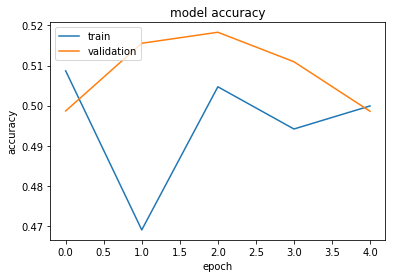

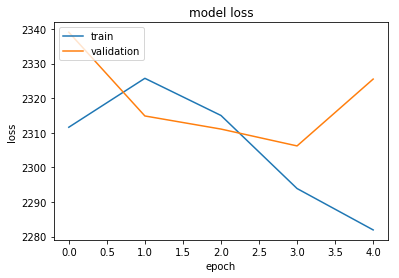

In [141]:
plt.plot(history.history['ac_metrics'])
plt.plot(history.history['val_ac_metrics'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [139]:
# Generate predictions (probabilities -- the output of the last layer)
# on new data using `predict`
print("Generate predictions for test")
predictions = kpe_model.predict([x_train[:500],x_mask[:500],x_pos[:500]])
print("predictions shape:", predictions.shape)


Generate predictions for test
predictions shape: (500, 154, 1)


In [275]:
calculate_f1(np.where(y_train[:500,:,0]-1==1,1,0),predictions[:,:,0],25,[5,10,15])

F1 [0.12139794 0.15248815 0.16843738] [0.1339     0.1301881  0.12874873] [0.13972958 0.24326879 0.3330662 ]


In [137]:
kpe_model.save('./checkpoints/inspec_final')


INFO:tensorflow:Assets written to: ./checkpoints/inspec_final\assets


In [169]:
t = 259
np.where(predictions[t,:,0][np.where((y_train[t,:,0])>0)]>=0.69)

(array([ 9, 10, 11, 18, 19, 21, 22], dtype=int64),)

In [170]:
np.argsort(-predictions[t,:,0])

array([ 19,  21,  10,   9,  11,  18,  22,  20,  24,   8,  12,  14,   4,
         5,   3,   7,  15,  27,  17,  23,  25,  16,   6,  28,  13,  34,
        26,  29,   2,   1,  35,  32,  30,  33,  36,  31,  38,  41,  40,
        37,  39,  42,  43,   0,  44,  45,  48,  55,  51,  52,  53,  46,
        54,  49,  50,  57,  47,  56,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83, 153,  84,  85,  86, 152,  87,  88,
       151,  89, 150,  90,  91, 149,  92, 148,  93, 147,  94, 146, 145,
        95, 144,  96, 143, 142,  97, 141,  98, 140, 139,  99, 138, 137,
       100, 136, 135, 101, 134, 133, 102, 132, 131, 103, 130, 104, 129,
       128, 105, 127, 126, 106, 125, 124, 107, 123, 122, 108, 121, 120,
       109, 119, 110, 118, 117, 111, 116, 112, 114, 113, 115], dtype=int64)

In [171]:
np.where((y_train[t,:,0]-1)==1)

(array([ 1,  2,  3,  9, 16, 36], dtype=int64),)

In [283]:

idx = np.argsort(-predictions[t,:,0])
preds = np.where(predictions[t,np.argsort(-predictions[t,:,0])]>=0.5)
scores = predictions [t,idx]
res = np.array(x_pos[t])[:,idx[preds[0]]]

keyphrases = collections.defaultdict(float)
for i in range(res.shape[1]):
    phrase = res[:,i]
    phrase = tokenizer.decode(list(x_train[t,phrase[0]:(phrase[1]+1)]))
    keyphrases[phrase] = max(keyphrases[phrase],scores[i][0])
keyphrases

defaultdict(float,
            {'steam turbine plant startup time': 0.66949254,
             'thermal stress': 0.6408367,
             'combined cycle power generation plant': 0.63953763,
             'aim': 0.6283839,
             'violating': 0.62470204,
             'candidate controllers': 0.62230295,
             'existing': 0.619974,
             'startup schedule': 0.5948295,
             'startup times': 0.5892381,
             'maximum thermal stress limits': 0.5877388,
             'control scheme': 0.58097446,
             'realized using': 0.5739425,
             'dynamic model': 0.55229133,
             'fuzzy logic approach': 0.50550425,
             'maximum thermal stress restrictions': 0.5027033,
             'performance': 0.5013375})